# Listening tests, speech and music

What would the fun in designing a filter be if we didn't hear it in action?

Speech clips are taken from EUSTACE ([1]). The listening tests are repeated with a 1st and 12th order WFIR, since the original paper that prompted this project ([2]) uses a 12th order Warped Linear Prediction filter.

In [1]:
import numpy, scipy, scipy.signal


def wfir(x: numpy.ndarray, fs: float, order: int) -> numpy.ndarray:
    def bark_warp_coef(fs):
        return 1.0674 * numpy.sqrt((2.0 / numpy.pi) * numpy.arctan(0.06583 * fs / 1000.0)) - 0.1916

    a = bark_warp_coef(fs)

    B = [-a.conjugate(), 1]
    A = [1, -a]

    ys = [0] * order

    ys[0] = scipy.signal.lfilter(B, A, x)
    for i in range(1, len(ys)):
        ys[i] = scipy.signal.lfilter(B, A, ys[i - 1])
        
    return ys[-1]

## Reintroducing filter coefficients, and inverse filtering

Until now I've been applying the WFIR directly, but the WLP/WFIR papers ([3], [4]) mention that the inverse filter should be applied to extract the residual signal. First, to build a proper WFIR, we need to reintroduce the notion of filter coefficients.

$$\hat X(z) = \left [\sum_{k=1}^{N}a_kD(z)^k \right ]X(z)$$

The output of the `wfir()` method defined above is simply:

$$Y(z) = \left[ D(z)^N \right ] X(z)$$

This means I've been implicitly using filter coefficients a<sub>1..k</sub> = [0, 0, ..., 1]. The inverse of the proper WFIR function is:

$$A(z) = 1 - \sum_{k=1}^{N}a_kD(z)^k$$

The residual signal, i.e. the desired output of an inverse WFIR filter, is:

$$R(z) = X(z) - \hat X(z)$$

This should mean that:

$$R(z) = A(z)X(z) = \left [ 1 - \sum_{k=1}^{N}a_kD(z)^k \right ]X(z)$$

In [2]:
def wfir(x: numpy.ndarray, fs: float, order: int) -> numpy.ndarray:
    def bark_warp_coef(fs):
        return 1.0674 * numpy.sqrt((2.0 / numpy.pi) * numpy.arctan(0.06583 * fs / 1000.0)) - 0.1916

    a = bark_warp_coef(fs)

    B = [-a.conjugate(), 1]
    A = [1, -a]
    ys = [0] * order

    ys[0] = scipy.signal.lfilter(B, A, x)
    for i in range(1, len(ys)):
        ys[i] = scipy.signal.lfilter(B, A, ys[i - 1])
        
    c = [1.0]*(order+1) # let's not use remez coefficients for now
    
    x_hat = c[0] * x
    for i in range(order):
        x_hat += c[i+1] * ys[i]

    r = x - x_hat
    return r

Finally, let's reintroduce the remez optimal filter coefficients, but now instead of copy/pasting it from a warped low-pass filter, let's decide what we want. Since we're using Bark for psychoacoustic/human ear modeling, let's continue on that track. I'll pick bandpass filter coefficients of 20Hz-20,000Hz, with a 1Hz transition (based loosely on research on the capabilities of human hearing).

In [3]:
def wfir(x: numpy.ndarray, fs: float, order: int) -> numpy.ndarray:
    def bark_warp_coef(fs):
        return 1.0674 * numpy.sqrt((2.0 / numpy.pi) * numpy.arctan(0.06583 * fs / 1000.0)) - 0.1916

    a = bark_warp_coef(fs)

    B = [-a.conjugate(), 1]
    A = [1, -a]
    ys = [0] * order

    ys[0] = scipy.signal.lfilter(B, A, x)
    for i in range(1, len(ys)):
        ys[i] = scipy.signal.lfilter(B, A, ys[i - 1])
        
    l = 20
    r = min(20000, fs/2 - 1)
    t = 1
        
    c = scipy.signal.remez(order+1, [0, l-t, l, r, r+t, 0.5*fs], [0, 1, 0], fs=fs)

    x_hat = c[0] * x
    for i in range(order):
        x_hat += c[i+1] * ys[i]

    r = x - x_hat
    return r

## Speech

### Female speech

In [4]:
from IPython.display import Audio
import scipy.io, scipy.io.wavfile


female_speech_clip = './speech_f.wav'
fs_1, x_1 = scipy.io.wavfile.read(female_speech_clip)              
Audio(x_1, rate=fs_1)

In [5]:
r1_1 = wfir(x_1, fs_1, 1)
Audio(r1_1, rate=fs_1)

In [6]:
r12_1 = wfir(x_1, fs_1, 12)
Audio(r12_1, rate=fs_1)

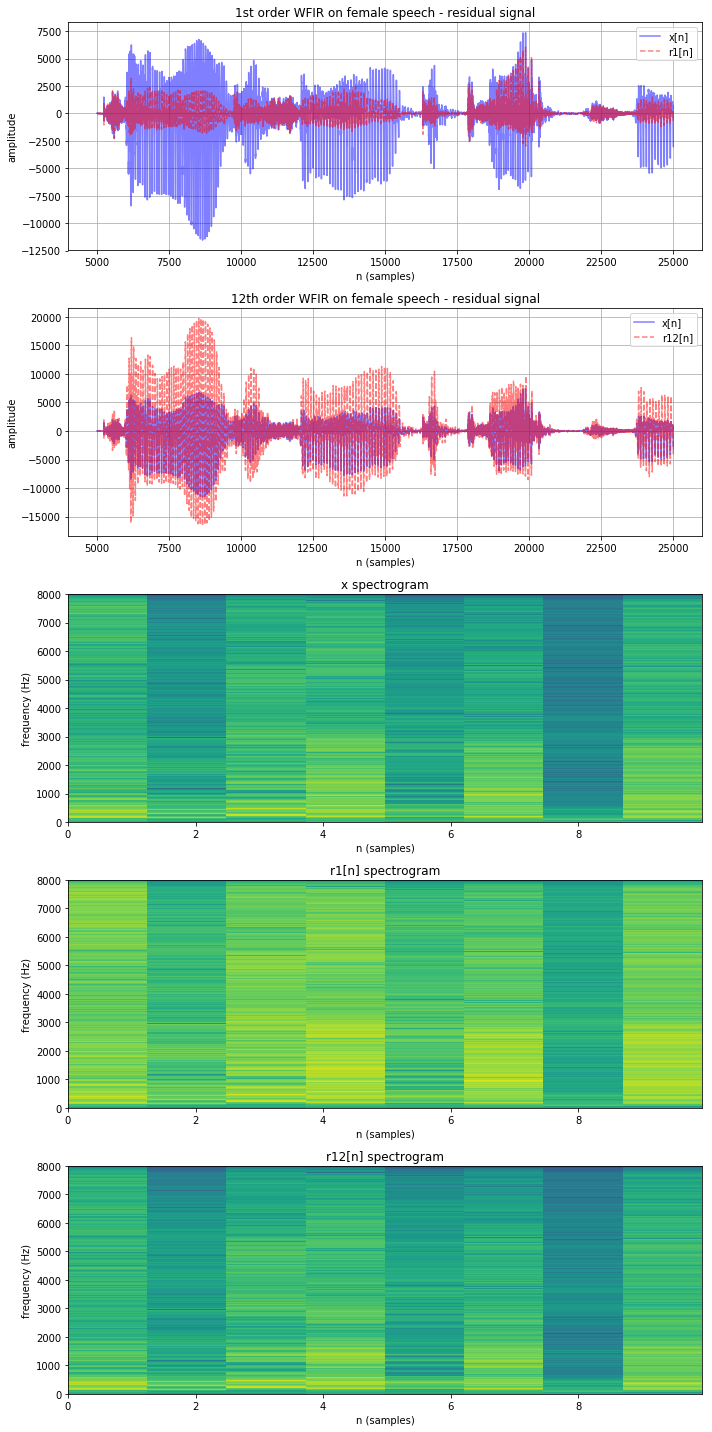

In [9]:
import matplotlib.pyplot as plt

l = 5000
r = 25000
samples = numpy.arange(r)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 20))

ax1.plot(samples[l:r], x_1[l:r], 'b', alpha=0.5, label='x[n]')
ax1.set_title(r'1st order WFIR on female speech - residual signal')
ax1.set_xlabel('n (samples)')
ax1.set_ylabel('amplitude')
ax1.plot(samples[l:r], r1_1[l:r], 'r', linestyle='--', alpha=0.5, label='r1[n]')
ax1.grid()
ax1.legend(loc='upper right')

ax2.plot(samples[l:r], x_1[l:r], 'b', alpha=0.5, label='x[n]')
ax2.set_title(r'12th order WFIR on female speech - residual signal')
ax2.set_xlabel('n (samples)')
ax2.set_ylabel('amplitude')
ax2.plot(samples[l:r], r12_1[l:r], 'r', linestyle='--', alpha=0.5, label='r12[n]')
ax2.grid()
ax2.legend(loc='upper right')

Pxx1, freqs1, bins1, im1 = ax3.specgram(x_1, NFFT=r-l, Fs=fs_1)
ax3.set_title(r'x spectrogram')
ax3.set_xlabel('n (samples)')
ax3.set_ylabel('frequency (Hz)')

Pxx2, freqs2, bins2, im2 = ax4.specgram(r1_1, NFFT=r-l, Fs=fs_1)
ax4.set_title(r'r1[n] spectrogram')
ax4.set_xlabel('n (samples)')
ax4.set_ylabel('frequency (Hz)')

Pxx3, freqs3, bins3, im3 = ax5.specgram(r12_1, NFFT=r-l, Fs=fs_1)
ax5.set_title(r'r12[n] spectrogram')
ax5.set_xlabel('n (samples)')
ax5.set_ylabel('frequency (Hz)')

plt.axis('tight')
fig.tight_layout()
plt.show()

## Male speech

In [10]:
male_speech_clip = './speech_m.wav'
fs_2, x_2 = scipy.io.wavfile.read(male_speech_clip)              
Audio(x_2, rate=fs_2)

In [11]:
r1_2 = wfir(x_2, fs_2, 1)
Audio(r1_2, rate=fs_2)

In [12]:
r12_2 = wfir(x_2, fs_2, 12)
Audio(r12_2, rate=fs_2)

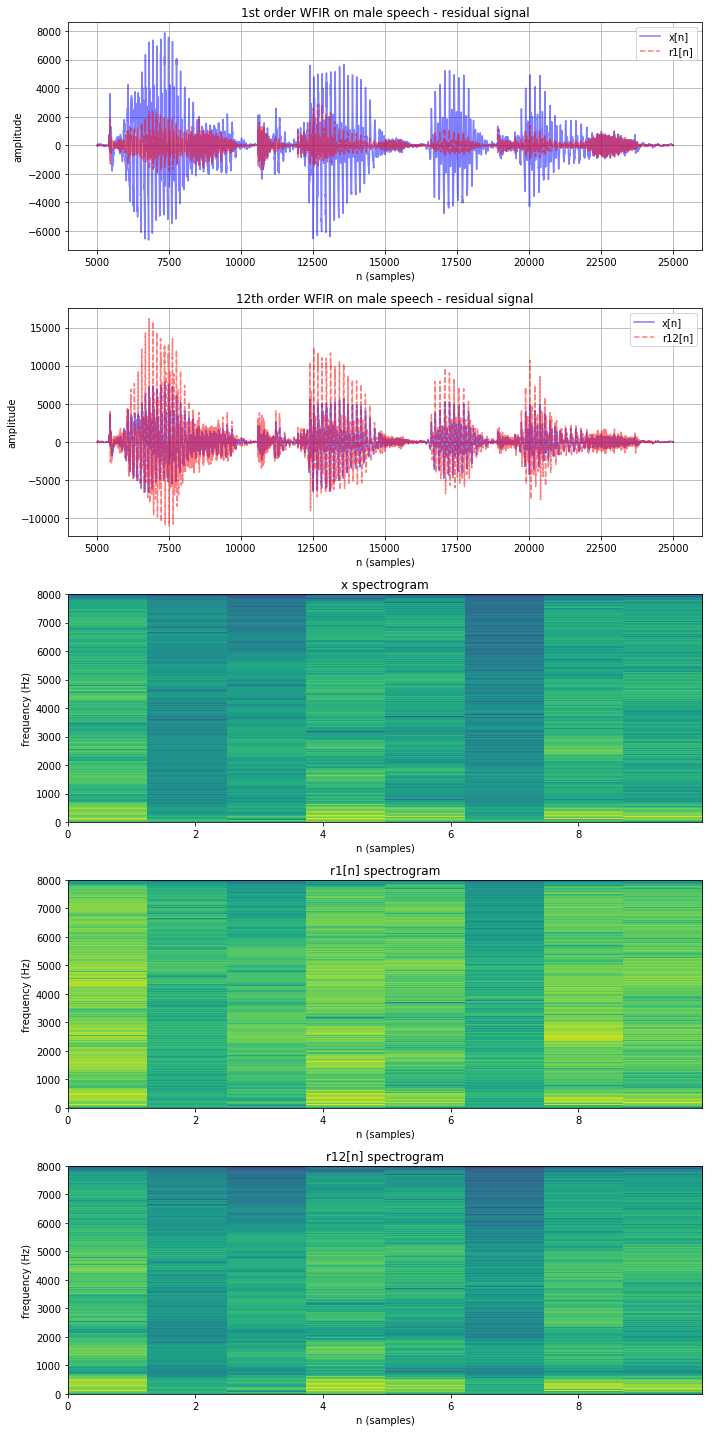

In [13]:
l = 5000
r = 25000
samples = numpy.arange(r)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 20))

ax1.plot(samples[l:r], x_2[l:r], 'b', alpha=0.5, label='x[n]')
ax1.set_title(r'1st order WFIR on male speech - residual signal')
ax1.set_xlabel('n (samples)')
ax1.set_ylabel('amplitude')
ax1.plot(samples[l:r], r1_2[l:r], 'r', linestyle='--', alpha=0.5, label='r1[n]')
ax1.grid()
ax1.legend(loc='upper right')

ax2.plot(samples[l:r], x_2[l:r], 'b', alpha=0.5, label='x[n]')
ax2.set_title(r'12th order WFIR on male speech - residual signal')
ax2.set_xlabel('n (samples)')
ax2.set_ylabel('amplitude')
ax2.plot(samples[l:r], r12_2[l:r], 'r', linestyle='--', alpha=0.5, label='r12[n]')
ax2.grid()
ax2.legend(loc='upper right')

Pxx1, freqs1, bins1, im1 = ax3.specgram(x_2, NFFT=r-l, Fs=fs_2)
ax3.set_title(r'x spectrogram')
ax3.set_xlabel('n (samples)')
ax3.set_ylabel('frequency (Hz)')

Pxx2, freqs2, bins2, im2 = ax4.specgram(r1_2, NFFT=r-l, Fs=fs_2)
ax4.set_title(r'r1[n] spectrogram')
ax4.set_xlabel('n (samples)')
ax4.set_ylabel('frequency (Hz)')

Pxx3, freqs3, bins3, im3 = ax5.specgram(r12_2, NFFT=r-l, Fs=fs_2)
ax5.set_title(r'r12[n] spectrogram')
ax5.set_xlabel('n (samples)')
ax5.set_ylabel('frequency (Hz)')

plt.axis('tight')
fig.tight_layout()
plt.show()

## Music

The clip chosen is from El Mestizo by Mestis ([5]). A caveat is that different genres and types of music will have different audio characteristics, so this is not a thorough comparison.

In [14]:
music_clip = './music.wav'
fs_3, x_3 = scipy.io.wavfile.read(music_clip)              
Audio(x_3, rate=fs_3)

In [15]:
r1_3 = wfir(x_3, fs_3, 1)
Audio(r1_3, rate=fs_3)

In [16]:
r12_3 = wfir(x_3, fs_3, 12)
Audio(r12_3, rate=fs_3)

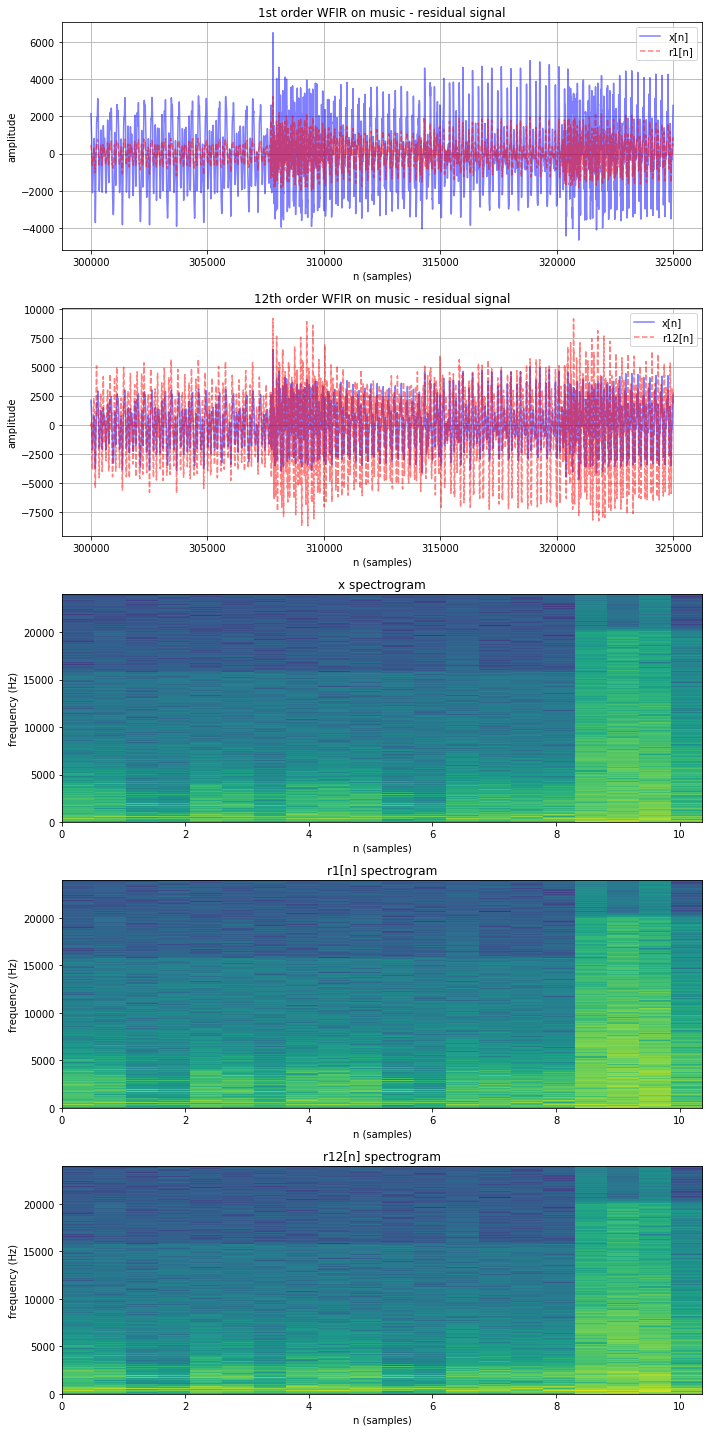

In [17]:
l = 300000
r = 325000
samples = numpy.arange(r)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 20))

ax1.plot(samples[l:r], x_3[l:r], 'b', alpha=0.5, label='x[n]')
ax1.set_title(r'1st order WFIR on music - residual signal')
ax1.set_xlabel('n (samples)')
ax1.set_ylabel('amplitude')
ax1.plot(samples[l:r], r1_3[l:r], 'r', linestyle='--', alpha=0.5, label='r1[n]')
ax1.grid()
ax1.legend(loc='upper right')

ax2.plot(samples[l:r], x_3[l:r], 'b', alpha=0.5, label='x[n]')
ax2.set_title(r'12th order WFIR on music - residual signal')
ax2.set_xlabel('n (samples)')
ax2.set_ylabel('amplitude')
ax2.plot(samples[l:r], r12_3[l:r], 'r', linestyle='--', alpha=0.5, label='r12[n]')
ax2.grid()
ax2.legend(loc='upper right')

Pxx1, freqs1, bins1, im1 = ax3.specgram(x_3, NFFT=r-l, Fs=fs_3)
ax3.set_title(r'x spectrogram')
ax3.set_xlabel('n (samples)')
ax3.set_ylabel('frequency (Hz)')

Pxx2, freqs2, bins2, im2 = ax4.specgram(r1_3, NFFT=r-l, Fs=fs_3)
ax4.set_title(r'r1[n] spectrogram')
ax4.set_xlabel('n (samples)')
ax4.set_ylabel('frequency (Hz)')

Pxx3, freqs3, bins3, im3 = ax5.specgram(r12_3, NFFT=r-l, Fs=fs_3)
ax5.set_title(r'r12[n] spectrogram')
ax5.set_xlabel('n (samples)')
ax5.set_ylabel('frequency (Hz)')

plt.axis('tight')
fig.tight_layout()
plt.show()

## Discussion

We heard some clips and saw some plots. Now the question is whether this supports what I've been reading about the effects of WFIRs.

The original reason I even started exploring WLP techniques was from a paper on multipitch analysis ([2]), which states the purpose of the prewhitening 12th order WLP filter step (before applying the autocorrelation-based algorithm):

>Inverse filtering with the WLP model yields the pre-whitened signal. To a certain extent, the whitening filter may be interpreted as functionally similar to the normalization of the hair cell activity level toward spectral flattening due to the adaptation and saturation effects

More:

>(the WLPC filter helps with) low-order spectral approximation, signal whitening ([6])

>Firstly, we estimate a spectral envelope of a signal; secondly, we compute a residual signal from the input and predicted signals; lastly, we apply the estimated spectral envelope on the residual signal with some warping parameter. The quality of the result of this procedure stands on the ability of the linear prediction algorithm to estimate the signal's spectrum, which grows with the order of prediction. The flatter the spectrum of the residual signal, the better the estimate of the input signal's spectrum. Spectral flatness of the residual signal is important specifically because it is a measure of how well the original spectral envelope has been removed from the input signal so new or warped envelope can be applied to it. To estimate spectral flatness we apply spectral flatness measure (SFM) which is based on the fact, that the residual signal from linear prediction should ideally have flat frequency characteristic ([7] ,[8])

We can use librosa's spectral_flatness ([9]) to do some measurements.

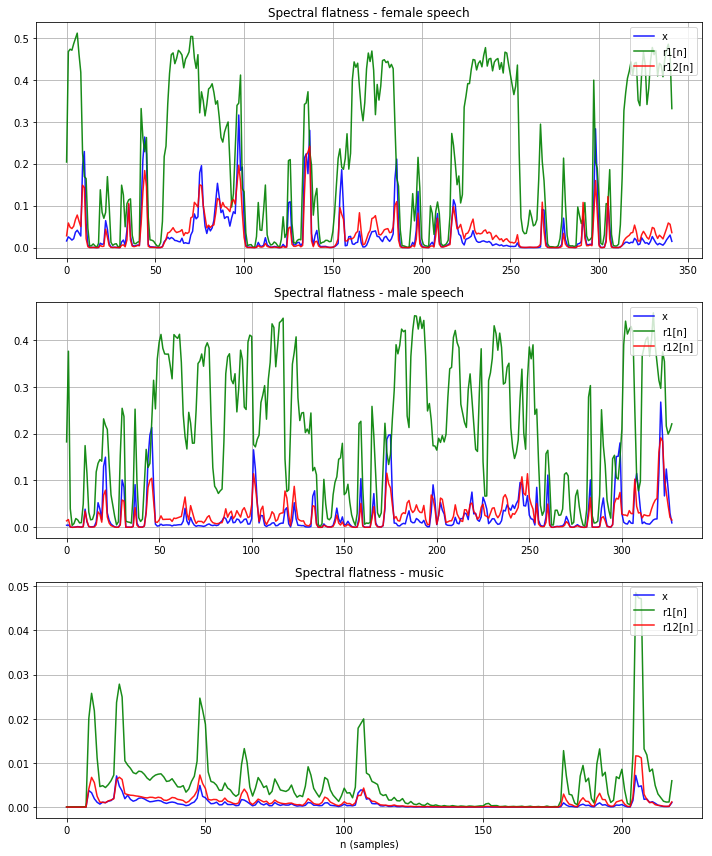

In [32]:
import librosa

sfm_female_speech = librosa.feature.spectral_flatness(x_1.astype(numpy.float))[0]
sfm_female_speech_wfir1 = librosa.feature.spectral_flatness(r1_1)[0]
sfm_female_speech_wfir12 = librosa.feature.spectral_flatness(r12_1)[0]

sfm_male_speech = librosa.feature.spectral_flatness(x_2.astype(numpy.float))[0]
sfm_male_speech_wfir1 = librosa.feature.spectral_flatness(r1_2)[0]
sfm_male_speech_wfir12 = librosa.feature.spectral_flatness(r12_2)[0]

sfm_music = librosa.feature.spectral_flatness(x_3.astype(numpy.float))[0]
sfm_music_wfir1 = librosa.feature.spectral_flatness(r1_3)[0]
sfm_music_wfir12 = librosa.feature.spectral_flatness(r12_3)[0]

fig3, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
plt.xlabel('n (samples)')

ax1.set_title('Spectral flatness - female speech')
ax1.plot(sfm_female_speech, color='b', alpha=0.9, label='x')
ax1.plot(sfm_female_speech_wfir1, color='g', alpha=0.9, label='r1[n]')
ax1.plot(sfm_female_speech_wfir12, color='r', alpha=0.9, label='r12[n]')
ax1.legend(loc='upper right')
ax1.grid()

ax2.set_title('Spectral flatness - male speech')
ax2.plot(sfm_male_speech, color='b', alpha=0.9, label='x')
ax2.plot(sfm_male_speech_wfir1, color='g', alpha=0.9, label='r1[n]')
ax2.plot(sfm_male_speech_wfir12, color='r', alpha=0.9, label='r12[n]')
ax2.legend(loc='upper right')
ax2.grid()

ax3.set_title('Spectral flatness - music')
ax3.plot(sfm_music[800:], color='b', alpha=0.9, label='x')
ax3.plot(sfm_music_wfir1[800:], color='g', alpha=0.9, label='r1[n]')
ax3.plot(sfm_music_wfir12[800:], color='r', alpha=0.9, label='r12[n]')
ax3.legend(loc='upper right')
ax3.grid()

fig3.tight_layout()
plt.show()

The output residual of the 1st-order WFIR does seem to be "more white." Subjectively, r1 (i.e. 1st-order WFIR residual) sounds "tinnier" than the original signal, while r12 (i.e. 12th-order WFIR residual) sounds muddier.

The important part (which we'll explore next) is reconstructing the original signal x from the residual r using a WIIR (Warped Infinite Impulse Response filter).

## References

1. White, L.S. and King, S. 2003. The EUSTACE speech corpus (http://www.cstr.ed.ac.uk/projects/eustace). Centre for Speech Technology Research, University of Edinburgh.

2. T. Tolonen and M. Karjalainen, "A computationally efficient multipitch analysis model," in IEEE Transactions on Speech and Audio Processing, vol. 8, no. 6, pp. 708-716, Nov. 2000. doi: 10.1109/89.876309

3. Harma A, Laine U. K., "A comparison of warped and conventional linear predictive coding," EDICS

4. P. Esquef, M. Karjalainen and V. Valimaki, "Detection of clicks in audio signals using warped linear prediction," 2002 14th International Conference on Digital Signal Processing Proceedings. DSP 2002 (Cat. No.02TH8628), Santorini, Greece, 2002, pp. 1085-1088 vol.2.

5. Song "El Mestizo" by band Mestis, Ahttps://www.youtube.com/watch?v=0kn2doStfp4

6. Ellis D., "Lecture 6: Linear Prediction (LPC)", ELEN E4896 Music Signal Processing, Dept. Electrical Engineering, Columbia University

7. Kruger, E & Werner Strube, Hans. (1988). "Linear Prediction on a Warped Frequency Scale," Acoustics, Speech and Signal Processing, IEEE Transactions on. 36. 1529 - 1531. doi: 10.1109/29.90384. 

8. J. Makhoul, "Linear prediction: A tutorial review," in Proceedings of the IEEE, vol. 63, no. 4, 1975, pp. 561–580.

9. Librosa documentation, "librosa.feature.spectral_flatness," https://librosa.github.io/librosa/generated/librosa.feature.spectral_flatness.html